<a href="https://colab.research.google.com/github/yiding0111/b9122_homework2/blob/main/TS_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Q2

### (1)

\begin{aligned}
& \text{Given the regression equation:} \\
& 12r_{t+1} = \alpha + \beta dy_t + e_{t+1} \\
& \\
& \text{Objective: Minimize the sum of squared residuals to find } \hat{\beta}: \\
& \min_{\alpha, \beta} \sum_{t=1}^{T}\left(12r_{t+1} - \alpha - \beta dy_t\right)^2 \\
& \\
& \text{First Order Condition (FOC) for } \beta: \\
& \frac{\partial}{\partial \beta} \sum_{t=1}^{T}\left(12r_{t+1} - \alpha - \beta dy_t\right)^2 = 0 \\
& 2 \sum_{t=1}^{T} \left(12r_{t+1} - \alpha - \beta dy_t\right)(-dy_t) = 0 \\
& \\
& \text{Solving for } \hat{\beta}: \\
& \hat{\beta} = \frac{\sum_{t=1}^{T} (12r_{t+1} dy_t) - \alpha \sum_{t=1}^{T} dy_t}{\sum_{t=1}^{T} (dy_t)^2} \\
& \\
& \text{Considering } e_{t+1} = 12r_{t+1} - \alpha - \beta dy_t, \text{ the expression for } \hat{\beta} \text{ becomes}: \\
& \hat{\beta} = \frac{\sum_{t=1}^{T} (\alpha + \beta dy_t + e_{t+1}) dy_t - \alpha \sum_{t=1}^{T} dy_t}{\sum_{t=1}^{T} (dy_t)^2} \\
& = \frac{\alpha \sum_{t=1}^{T} dy_t + \beta \sum_{t=1}^{T} (dy_t)^2 + \sum_{t=1}^{T} e_{t+1} dy_t - \alpha \sum_{t=1}^{T} dy_t}{\sum_{t=1}^{T} (dy_t)^2} \\
& = \beta + \frac{\sum_{t=1}^{T} e_{t+1} dy_t}{\sum_{t=1}^{T} (dy_t)^2} \\
& \\
& \text{Bias Assessment:} \\
& \text{If } E[e_{t+1} dy_t] \neq 0, \text{ then } \hat{\beta} \text{ is biased.} \\
& \text{Bias}(\hat{\beta}) = \frac{E[\sum_{t=1}^{T} e_{t+1} dy_t]}{\sum_{t=1}^{T} (dy_t)^2}. \\
& \\
& \text{Conclusion:} \\
& \text{The OLS estimator } \hat{\beta} \text{ can be biased if } E[e_{t+1} dy_t] \neq 0, \text{ indicating correlation between } e_{t+1} \text{ and } dy_t.
\end{aligned}

### (2)

In [ ]:
import pandas as pd
from statsmodels.tsa.api import VAR
import numpy as np
from numpy.linalg import inv
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('homework3data.csv')

# Create a new column for the shifted log excess return to represent t+1
data['log_excess_ret_t+1'] = data['log_excess_ret'].shift(-1)

data.dropna(inplace=True)

var_df = data[['log_excess_ret', 'div_yld']]

bic_scores = {}

# Fit VAR models for lag orders from 1 to 3 and calculate BIC for each
for lag_order in range(1, 4):
    model = VAR(var_df)
    result = model.fit(lag_order)
    bic_scores[lag_order] = result.bic

# Determine the optimal lag order with the lowest BIC
best_lag = min(bic_scores, key=bic_scores.get)

# Refit VAR model using the optimal lag order
optimal_model = VAR(var_df).fit(best_lag)

print(f"BIC for different lag orders: {bic_scores}")
print(f"Optimal lag order based on BIC: {best_lag}")

print(optimal_model.summary())

BIC for different lag orders: {1: -20.82301301154453, 2: -20.786216200569513, 3: -20.7508010941584}
Optimal lag order based on BIC: 1
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, Mar, 2024
Time:                     00:45:05
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -20.8230
Nobs:                     718.000    HQIC:                  -20.8465
Log likelihood:           5457.60    FPE:                8.71107e-10
AIC:                     -20.8613    Det(Omega_mle):     8.63873e-10
--------------------------------------------------------------------
Results for equation log_excess_ret
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.003126         0.004985           -0.627   

In [ ]:
parameters = optimal_model.params

intercepts = parameters.iloc[0]  # First row for intercepts
coefficients = parameters.iloc[1:]  # Remaining rows for coefficients

residual_covariance = optimal_model.sigma_u

intercepts_np = intercepts.values.reshape(-1, 1)  # Reshape for consistency as a column vector
coefficients_np = coefficients.values  # 2D array for coefficients
residual_covariance_np = residual_covariance.values  # 2D array for the covariance matrix

coefficients_np_transposed = coefficients_np.T

print("Intercept Vector (Constants):\n", intercepts_np)
print("\nCoefficient Matrix (after transposing):\n", coefficients_np_transposed)
print("\nResidual Covariance Matrix:\n", residual_covariance_np)

Intercept Vector (Constants):
 [[-0.00312558]
 [ 0.00033642]]

Coefficient Matrix (after transposing):
 [[ 0.08474723  0.24699369]
 [-0.00314316  0.9879602 ]]

Residual Covariance Matrix:
 [[ 1.91983912e-03 -5.77006310e-05]
 [-5.77006310e-05  2.18415991e-06]]


### (3)

In [ ]:
def compute_beta_OLS(phi_11, phi_12, phi_21, phi_22, var1, cov12, var2):
    # Construct the coefficient matrix and residual covariance matrix
    coefficients = np.array([[phi_11, phi_12], [phi_21, phi_22]])
    residuals_covariance = np.array([[var1, cov12], [cov12, var2]])
    # Calculate the Sigma0 and Sigma1 matrices for the long-run variance-covariance matrix
    vec_sigma0 = inv(np.eye(4) - np.kron(coefficients, coefficients)) @ residuals_covariance.flatten()
    sigma0_matrix = vec_sigma0.reshape(2, 2)
    sigma1_matrix = coefficients @ sigma0_matrix
    # Compute the OLS beta based on the Sigma matrices
    ols_beta = 12 * sigma1_matrix[0, 1] / sigma0_matrix[1, 1]
    return ols_beta

def calculate_gradient(beta_calc_function, parameters, epsilon=1e-5):
    # Initialize a gradient vector with zeros
    gradient_vector = np.zeros(len(parameters))
    # Compute the original beta value
    original_beta_value = beta_calc_function(*parameters)

    # Iterate through each parameter to calculate the gradient
    for index in range(len(parameters)):
        # Create a copy of parameters and perturb the current parameter by a small epsilon
        perturbed_parameters = np.array(parameters, copy=True)
        perturbed_parameters[index] += epsilon
        # Calculate the beta value with the perturbed parameter
        perturbed_beta_value = beta_calc_function(*perturbed_parameters)
        # Compute the gradient for this parameter
        gradient_vector[index] = (perturbed_beta_value - original_beta_value) / epsilon

    return gradient_vector.tolist()

In [ ]:
# Extract coefficients and residual matrix values from the VAR model
phi_11_value = float(coefficients_np[0, 0])
phi_12_value = float(coefficients_np[0, 1])
phi_21_value = float(coefficients_np[1, 0])
phi_22_value = float(coefficients_np[1, 1])
residual_variance_1 = float(residual_covariance_np[0, 0])
residual_covariance = float(residual_covariance_np[1, 0])
residual_variance_2 = float(residual_covariance_np[1, 1])

# Calculate the OLS beta using the updated function
ols_beta_Q1 = compute_beta_OLS(phi_11_value, phi_12_value, phi_21_value, phi_22_value, residual_variance_1, residual_covariance, residual_variance_2)
print("OLS beta:", ols_beta_Q1)

parameters = [phi_11_value, phi_12_value, phi_21_value, phi_22_value, residual_variance_1, residual_covariance, residual_variance_2]

# Calculate the gradient of the OLS beta using the delta method
gradient = calculate_gradient(compute_beta_OLS, parameters)
# Prepend zeros for constant terms which are irrelevant to the OLS beta calculation
gradient_with_constants = np.array([0, 0] + gradient)

print("Calculated Gradient:", gradient_with_constants)

OLS beta: -0.04556460326984141
Calculated Gradient: [0.00000000e+00 0.00000000e+00 3.31771746e-02 1.31835093e+01
 8.06543453e-02 3.34830465e-01 8.21908693e+00 2.64098559e+02
 3.63942666e+01]


In [ ]:
variance_covariance_matrix = optimal_model.cov_params()

simplified_row_indices = ['_'.join(map(str, index)) for index in variance_covariance_matrix.index.to_flat_index()]
simplified_column_indices = ['_'.join(map(str, column)) for column in variance_covariance_matrix.columns.to_flat_index()]

variance_covariance_matrix.index = simplified_row_indices
variance_covariance_matrix.columns = simplified_column_indices

simplified_var_cov_matrix = pd.DataFrame(variance_covariance_matrix)

print(simplified_var_cov_matrix)

# Extracting the variance-covariance matrix 'V' from the model results
V = pd.DataFrame(optimal_model.cov_params())

V.index = ['_'.join(map(str, idx)) for idx in V.index.to_flat_index()]
V.columns = ['_'.join(map(str, col)) for col in V.columns.to_flat_index()]

n_bootstraps = 2000
bootstrap_estimates = []

for _ in range(n_bootstraps):
    bootstrap_sample = var_df.sample(n=len(var_df), replace=True)
    # Fit the VAR model to the bootstrap sample with an assumed lag order of 1
    bootstrap_results = VAR(bootstrap_sample).fit(1)
    bootstrap_cov_matrix = np.cov(bootstrap_results.resid, rowvar=False)
    bootstrap_estimates.append([bootstrap_cov_matrix[0, 0], bootstrap_cov_matrix[0, 1], bootstrap_cov_matrix[1, 1]])

bootstrap_df = pd.DataFrame(bootstrap_estimates, columns=['Var1', 'Cov12', 'Var2'])
# Calculating the covariance of bootstrap estimates
covariance_of_residuals = np.cov(bootstrap_df.T)

expanded_columns = V.columns.tolist() + ['res_var1', 'res_cov', 'res_var2']
expanded_rows = V.index.tolist() + ['res_var1', 'res_cov', 'res_var2']
expanded_V = pd.DataFrame(np.zeros((9, 9)), columns=expanded_columns, index=expanded_rows)

expanded_V.iloc[:len(V), :len(V)] = V
expanded_V.iloc[len(V):, len(V):] = covariance_of_residuals

expanded_V = pd.DataFrame(expanded_V)

print(expanded_V)

                                  const_log_excess_ret  const_div_yld  \
const_log_excess_ret                      2.484826e-05  -7.468128e-07   
const_div_yld                            -7.468128e-07   2.826934e-08   
L1.log_excess_ret_log_excess_ret         -2.057001e-05   6.182303e-07   
L1.log_excess_ret_div_yld                 6.182303e-07  -2.340206e-08   
L1.div_yld_log_excess_ret                -7.782921e-04   2.339151e-05   
L1.div_yld_div_yld                        2.339151e-05  -8.854463e-07   

                                  L1.log_excess_ret_log_excess_ret  \
const_log_excess_ret                                 -2.057001e-05   
const_div_yld                                         6.182303e-07   
L1.log_excess_ret_log_excess_ret                      1.390438e-03   
L1.log_excess_ret_div_yld                            -4.178953e-05   
L1.div_yld_log_excess_ret                             5.247209e-04   
L1.div_yld_div_yld                                   -1.577045e-05  

In [ ]:
gradient_with_constants[3], gradient_with_constants[4] = gradient_with_constants[4], gradient_with_constants[3]  # Adjusting the order of gradients

scaled_expanded_V_matrix = np.matrix(expanded_V.values) * len(var_df)

# Calculate the standard error of OLS beta using the gradient and the scaled variance-covariance matrix
SE_beta_OLS = np.sqrt(gradient_with_constants.T @ scaled_expanded_V_matrix @ gradient_with_constants / len(var_df))*100

print('The standard error of the OLS beta is', float(SE_beta_OLS))

The standard error of the OLS beta is 217.852362243008


In [ ]:
def simplify_var_cov_matrix(var_model):
    var_cov_matrix = var_model.cov_params()

    row_labels = ['_'.join(str(idx) for idx in multi_idx) for multi_idx in var_cov_matrix.index.to_flat_index()]
    col_labels = ['_'.join(str(col) for col in multi_col) for multi_col in var_cov_matrix.columns.to_flat_index()]
    var_cov_matrix.index = row_labels
    var_cov_matrix.columns = col_labels

    return var_cov_matrix

simplified_var_cov_matrix = simplify_var_cov_matrix(optimal_model)
print(simplified_var_cov_matrix)

n_bootstraps = 10000
bootstrap_estimates = []

for _ in range(n_bootstraps):
    bootstrap_sample = var_df.sample(n=len(var_df), replace=True)
    # Fit the VAR model to the bootstrap sample with an assumed lag order of 1
    bootstrap_results = VAR(bootstrap_sample).fit(1)
    bootstrap_cov_matrix = np.cov(bootstrap_results.resid, rowvar=False)
    bootstrap_estimates.append([bootstrap_cov_matrix[0, 0], bootstrap_cov_matrix[0, 1], bootstrap_cov_matrix[1, 1]])

# Creating a DataFrame from bootstrap estimates
bootstrap_df = pd.DataFrame(bootstrap_estimates, columns=['Var1', 'Cov12', 'Var2'])
covariance_of_residuals = np.cov(bootstrap_df.T)

expanded_columns = V.columns.tolist() + ['res_var1', 'res_cov', 'res_var2']
expanded_rows = V.index.tolist() + ['res_var1', 'res_cov', 'res_var2']
expanded_V = pd.DataFrame(np.zeros((9, 9)), columns=expanded_columns, index=expanded_rows)

expanded_V.iloc[:len(V), :len(V)] = V
expanded_V.iloc[len(V):, len(V):] = covariance_of_residuals

expanded_V = pd.DataFrame(expanded_V)

print(expanded_V)

                                  const_log_excess_ret  const_div_yld  \
const_log_excess_ret                      2.484826e-05  -7.468128e-07   
const_div_yld                            -7.468128e-07   2.826934e-08   
L1.log_excess_ret_log_excess_ret         -2.057001e-05   6.182303e-07   
L1.log_excess_ret_div_yld                 6.182303e-07  -2.340206e-08   
L1.div_yld_log_excess_ret                -7.782921e-04   2.339151e-05   
L1.div_yld_div_yld                        2.339151e-05  -8.854463e-07   

                                  L1.log_excess_ret_log_excess_ret  \
const_log_excess_ret                                 -2.057001e-05   
const_div_yld                                         6.182303e-07   
L1.log_excess_ret_log_excess_ret                      1.390438e-03   
L1.log_excess_ret_div_yld                            -4.178953e-05   
L1.div_yld_log_excess_ret                             5.247209e-04   
L1.div_yld_div_yld                                   -1.577045e-05  

In [ ]:
gradient_with_constants[3], gradient_with_constants[4] = gradient_with_constants[4], gradient_with_constants[3]

scaled_expanded_V_matrix = np.matrix(expanded_V.values) * len(var_df)

SE_beta_OLS = np.sqrt(gradient_with_constants.T @ scaled_expanded_V_matrix @ gradient_with_constants / len(var_df))*100

print('The standard error of the OLS beta is', float(SE_beta_OLS))

The standard error of the OLS beta is 1.938226364533609


### (4)

In [ ]:
X_1 = sm.add_constant(np.ones(len(data)))

y_r = data['log_excess_ret']

model_1 = sm.OLS(y_r, X_1)
results = model_1.fit()
ret_residual = sm.OLS(y_r, X_1).fit().resid

# Fit an AutoReg model to 'div_yld' with 1 lag and extract residuals
div_yield_residuals = AutoReg(data['div_yld'], lags=1).fit().resid

residuals_df = pd.DataFrame({'ret_residual': ret_residual, 'div_yield_residual': div_yield_residuals})

correlation_matrix = residuals_df.corr()
print(correlation_matrix)

                    ret_residual  div_yield_residual
ret_residual            1.000000           -0.890832
div_yield_residual     -0.890832            1.000000


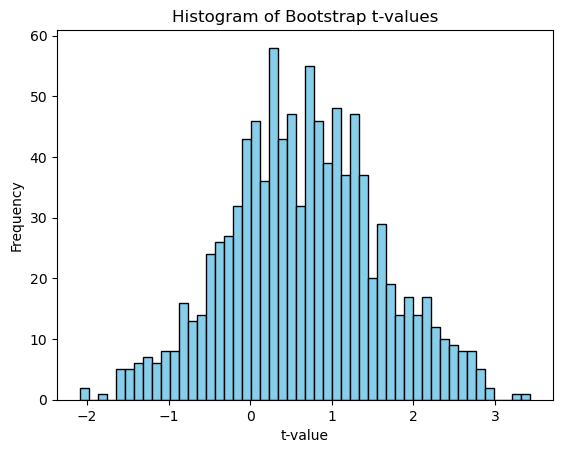

In [ ]:
var_data_2 = data['div_yld'].to_frame()
auto_reg_model = AutoReg(var_data_2, lags=1)
fitted_auto_reg_model = auto_reg_model.fit()

def bootstrap_t_values(df, n_iterations=1000, original_data=data, ols_results=results, auto_reg_model=fitted_auto_reg_model):
    t_values = []
    for _ in range(n_iterations):

        sampled_pairs = df.sample(n=len(df), replace=True)
        resid_ret = sampled_pairs['ret_residual']
        resid_div = sampled_pairs['div_yield_residual']

        # Reconstruct the return series using residuals
        ret_bootstrap = ols_results.params[0] + resid_ret

        # Reconstruct the dividend series using autoregression
        div_bootstrap = [original_data['div_yld'].iloc[0]]
        for i in range(1, len(resid_div)):
            div_t1 = auto_reg_model.params[0] + auto_reg_model.params[1] * div_bootstrap[i-1] + resid_div.iloc[i]
            div_bootstrap.append(div_t1)

        y = [value * 12 for value in ret_bootstrap[1:]]
        X = sm.add_constant(div_bootstrap[:-1])

        # Fit the regression model on bootstrap samples
        model = sm.OLS(y, X).fit()

        t_values.append(model.tvalues[1])

    return t_values

df_adjusted = residuals_df.iloc[1:,]

t_value_results = bootstrap_t_values(df_adjusted, 1000, data, results, fitted_auto_reg_model)

plt.hist(t_value_results, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('t-value')
plt.ylabel('Frequency')
plt.title('Histogram of Bootstrap t-values')
plt.show()

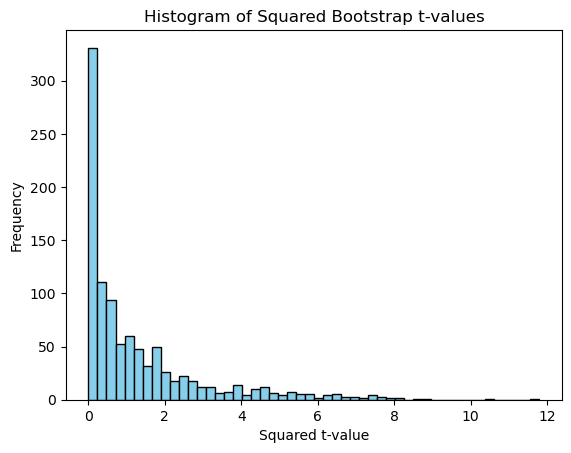

Proportion of squared t-values > 3.84: 0.098


In [ ]:
t_value_square = [item ** 2 for item in t_value_results]

# Plotting the histogram of squared t-values
plt.hist(t_value_square, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Squared t-value')
plt.ylabel('Frequency')
plt.title('Histogram of Squared Bootstrap t-values')
plt.show()

# Calculate the proportion of squared t-values greater than 3.84
proportion_above_critical = sum(i > 3.84 for i in t_value_square) / len(t_value_square)
print("Proportion of squared t-values > 3.84:", proportion_above_critical)

A well-calibrated test, with respect to its size, suggests that at a 0.05 significance level, the likelihood of committing a Type I error should be close to 5%. Yet, in the current scenario, this likelihood is slightly surpassing the predefined threshold of 0.05.

### (5)

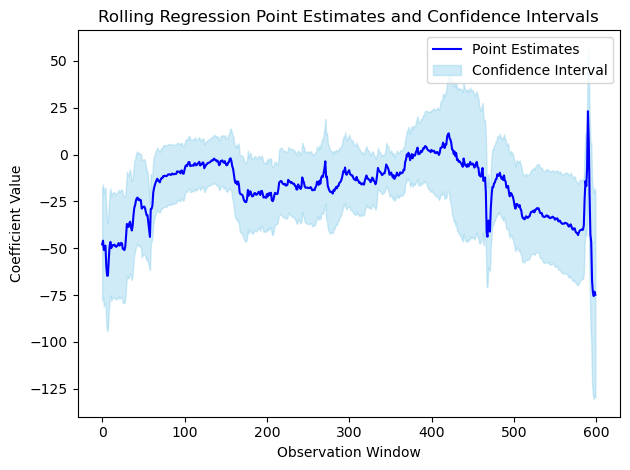

In [ ]:
coefficients = []
conf_int_lower = []
conf_int_higher = []

window_size = 120

for start_index in range(len(data) - window_size + 1):
    data_window = data.iloc[start_index:start_index + window_size]

    # Set up the dependent variable (y) and independent variable (X) for regression
    y = 12 * data_window['log_excess_ret'].iloc[:-1]  # Annualize returns
    X = sm.add_constant(data_window['div_yld'].iloc[:-1])

    # Fit the OLS regression model
    rolling_model = sm.OLS(y, X).fit()

    # Extract the coefficient for 'div_yld' and its confidence interval
    coef = rolling_model.params['div_yld']
    ci_lower, ci_higher = rolling_model.conf_int().loc['div_yld']

    coefficients.append(coef)
    conf_int_lower.append(ci_lower)
    conf_int_higher.append(ci_higher)

fig, ax = plt.subplots()

ax.plot(coefficients, label='Point Estimates', color='blue')
ax.fill_between(range(len(coefficients)), conf_int_lower, conf_int_higher, color='skyblue', alpha=0.4, label='Confidence Interval')

ax.set_xlabel('Observation Window')
ax.set_ylabel('Coefficient Value')
ax.set_title('Rolling Regression Point Estimates and Confidence Intervals')
ax.legend()

plt.tight_layout()
plt.show()

The parameter estimates exhibit significant variability, especially in the later segments. This highlights the critical role of choosing specific time periods for analysis, as the relationship between returns and dividends can shift in response to macroeconomic trends and policy adjustments.